# QuTiP example: Bloch-Redfield Master Equation

J.R. Johansson and P.D. Nation

For more information about QuTiP see [http://qutip.org](http://qutip.org)

In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip import *

## Single qubit dynamics

In [3]:
def qubit_integrate(w, theta, gamma1, gamma2, psi0, tlist):
    # Hamiltonian
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()
    sm = sigmam()
    H = w * (np.cos(theta) * sz + np.sin(theta) * sx)

    # Lindblad master equation
    c_op_list = []
    n_th = 0.0 # zero temperature
    rate = gamma1 * (n_th + 1)
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm)
    rate = gamma1 * n_th
    if rate > 0.0:
        c_op_list.append(np.sqrt(rate) * sm.dag())
    lme_results = mesolve(H, psi0, tlist, c_op_list, [sx, sy, sz]).expect

    # Bloch-Redfield tensor
    #ohmic_spectrum = lambda w: gamma1 * w / (2*pi)**2 * (w > 0.0)    
    def ohmic_spectrum(w):
        if w == 0.0:
            # dephasing inducing noise
            return gamma1/2
        else:
            # relaxation inducing noise
            return gamma1/2 * w / (2*np.pi) * (w > 0.0)
            

    brme_results = brmesolve(H, psi0, tlist, [[sx, ohmic_spectrum]], [sx, sy, sz]).expect

    # alternative:
    #R, ekets = bloch_redfield_tensor(H, [sx], [ohmic_spectrum])
    #brme_results = bloch_redfield_solve(R, ekets, psi0, tlist, [sx, sy, sz])   

    return lme_results, brme_results

In [4]:
w     = 1.0 * 2 * np.pi  # qubit angular frequency
theta = 0.05 * np.pi     # qubit angle from sigma_z axis (toward sigma_x axis)
gamma1 = 0.5          # qubit relaxation rate
gamma2 = 0.0          # qubit dephasing rate
# initial state
a = 0.8
psi0 = (a* basis(2,0) + (1-a)*basis(2,1))/(np.sqrt(a**2 + (1-a)**2))
tlist = np.linspace(0,15,5000)

In [5]:
lme_results, brme_results = qubit_integrate(w, theta, gamma1, gamma2, psi0, tlist) 

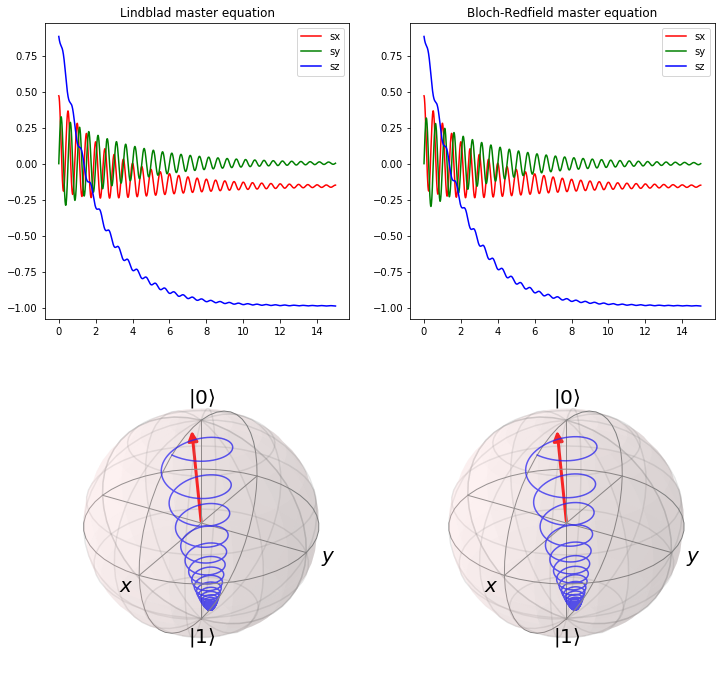

In [6]:
fig = figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1)
title('Lindblad master equation')
ax.plot(tlist, lme_results[0], 'r')
ax.plot(tlist, lme_results[1], 'g')
ax.plot(tlist, lme_results[2], 'b')
ax.legend(("sx", "sy", "sz"))

ax = fig.add_subplot(2,2,2)
title('Bloch-Redfield master equation')
ax.plot(tlist, brme_results[0], 'r')
ax.plot(tlist, brme_results[1], 'g')
ax.plot(tlist, brme_results[2], 'b')
ax.legend(("sx", "sy", "sz"))


sphere=Bloch(axes=fig.add_subplot(2,2,3, projection='3d'))
sphere.add_points([lme_results[0],lme_results[1],lme_results[2]], meth='l')
sphere.vector_color = ['r']
sphere.add_vectors([sin(theta),0,cos(theta)])
sphere.make_sphere()

sphere=Bloch(axes=fig.add_subplot(2,2,4, projection='3d'))
sphere.add_points([brme_results[0],brme_results[1],brme_results[2]], meth='l')
sphere.vector_color = ['r']
sphere.add_vectors([sin(theta),0,cos(theta)])
sphere.make_sphere()

## Coupled qubits

In [7]:
def qubit_integrate(w, theta, g, gamma1, gamma2, psi0, tlist):
    #
    # Hamiltonian
    #
    sx1 = tensor(sigmax(),qeye(2))
    sy1 = tensor(sigmay(),qeye(2))
    sz1 = tensor(sigmaz(),qeye(2))
    sm1 = tensor(sigmam(),qeye(2))

    sx2 = tensor(qeye(2),sigmax())
    sy2 = tensor(qeye(2),sigmay())
    sz2 = tensor(qeye(2),sigmaz())
    sm2 = tensor(qeye(2),sigmam())
    
    H  = w[0] * (np.cos(theta[0]) * sz1 + np.sin(theta[0]) * sx1) # qubit 1
    H += w[1] * (np.cos(theta[1]) * sz2 + np.sin(theta[1]) * sx2) # qubit 2
    H += g * sx1 * sx2                                      # interaction

    #
    # Lindblad master equation
    #
    c_op_list = []
    n_th = 0.0 # zero temperature
    rate = gamma1[0] * (n_th + 1)
    if rate > 0.0: c_op_list.append(np.sqrt(rate) * sm1)
    rate = gamma1[1] * (n_th + 1)
    if rate > 0.0: c_op_list.append(np.sqrt(rate) * sm2)
        
    lme_results = mesolve(H, psi0, tlist, c_op_list, [sx1, sy1, sz1]).expect 

    #
    # Bloch-Redfield tensor
    #  
    def ohmic_spectrum1(w):
        if w == 0.0:
            # dephasing inducing noise
            return gamma1[0]/2
        else:
            # relaxation inducing noise
            return gamma1[0] * w / (2*np.pi) * (w > 0.0)
        
    def ohmic_spectrum2(w):
        if w == 0.0:
            # dephasing inducing noise
            return gamma1[1]/2
        else:
            # relaxation inducing noise
            return gamma1[1] * w / (2*np.pi) * (w > 0.0)

    brme_results = brmesolve(H, psi0, tlist, [[sx1,ohmic_spectrum1], [sx2,ohmic_spectrum2]], [sx1, sy1, sz1]).expect

    # alternative:
    #R, ekets = bloch_redfield_tensor(H, [sx1, sx2], [ohmic_spectrum1, ohmic_spectrum2])       
    #brme_results = brmesolve(R, ekets, psi0, tlist, [sx1, sy1, sz1])   

    return lme_results, brme_results

In [8]:
w     = array([1.0, 1.0]) * 2 * np.pi   # qubit angular frequency
theta = array([0.15, 0.45]) * 2 * np.pi # qubit angle from sigma_z axis (toward sigma_x axis)
gamma1 = [0.25, 0.35]                # qubit relaxation rate
gamma2 = [0.0, 0.0]                  # qubit dephasing rate
g      = 0.1 * 2 * np.pi
# initial state
a = 0.8
psi1 = (a*basis(2,0) + (1-a)*basis(2,1))/(np.sqrt(a**2 + (1-a)**2))
psi2 = ((1-a)*basis(2,0) + a*basis(2,1))/(np.sqrt(a**2 + (1-a)**2))
psi0 = tensor(psi1, psi2)

tlist = np.linspace(0,15,5000)

In [9]:
lme_results, brme_results = qubit_integrate(w, theta, g, gamma1, gamma2, psi0, tlist)

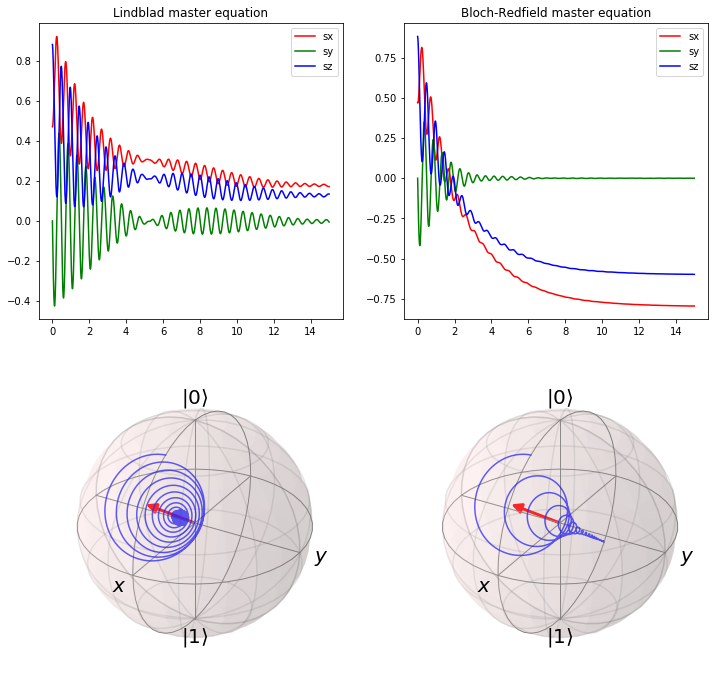

In [10]:
fig = figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1)
title('Lindblad master equation')
ax.plot(tlist, lme_results[0], 'r')
ax.plot(tlist, lme_results[1], 'g')
ax.plot(tlist, lme_results[2], 'b')
ax.legend(("sx", "sy", "sz"))

ax = fig.add_subplot(2,2,2)
title('Bloch-Redfield master equation')
ax.plot(tlist, brme_results[0], 'r')
ax.plot(tlist, brme_results[1], 'g')
ax.plot(tlist, brme_results[2], 'b')
ax.legend(("sx", "sy", "sz"))

sphere=Bloch(axes=fig.add_subplot(2,2,3, projection='3d'))
sphere.add_points([lme_results[0],lme_results[1],lme_results[2]], meth='l')
sphere.vector_color = ['r']
sphere.add_vectors([sin(theta[0]),0,cos(theta[0])])
sphere.make_sphere()

sphere=Bloch(axes=fig.add_subplot(2,2,4, projection='3d'))
sphere.add_points([brme_results[0],brme_results[1],brme_results[2]], meth='l')
sphere.vector_color = ['r']
sphere.add_vectors([sin(theta[0]),0,cos(theta[0])])
sphere.make_sphere()

## Versions

In [11]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.13.1
SciPy,0.19.1
matplotlib,2.0.2
Cython,0.25.2
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,6.1.0
Python,"3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]"
OS,posix [darwin]
